In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
sns.set(rc={'figure.figsize':(10, 8)})

In [2]:
df = pd.read_csv('loans.csv', sep =',')
df

,history,term,income,risk
0,excellent,3,high,low
1,fair,10,low,high
2,fair,3,high,low
3,bad,10,high,high
4,excellent,3,low,low
5,fair,10,high,low
6,bad,3,high,low
7,bad,10,low,high
8,excellent,10,low,low


    АНАЛИЗ

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   history  9 non-null      object
 1   term     9 non-null      int64 
 2   income   9 non-null      object
 3   risk     9 non-null      object
dtypes: int64(1), object(3)
memory usage: 416.0+ bytes


Наш целевой признак - risk. Он является категориальным, поэтому задача классификации.

In [4]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
history,9,3,excellent,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
term,9.0,NaN,NaN,NaN,6.888889,3.689324,3.0,3.0,10.0,10.0,10.0
income,9,2,high,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
risk,9,2,low,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


    ПРЕДОБРАБОТКА

Перед тем как работать с признаками и обучать нашу программу, переведём все категориальные данные в числовые для дальнейшей работы.

In [5]:
cols = ['history', 'income', 'risk']
df[cols] = df[cols].apply(lambda x: pd.factorize(x)[0] + 1)

df

,history,term,income,risk
0,1,3,1,1
1,2,10,2,2
2,2,3,1,1
3,3,10,1,2
4,1,3,2,1
5,2,10,1,1
6,3,3,1,1
7,3,10,2,2
8,1,10,2,1


Далее по старой схеме - делим датасет на целевой признак и признаки для обучения

In [6]:
X = df.drop(columns = ['risk'])
y = df.risk

Теперь разделим эти признаки для тренировки и теста

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    ДЕРЕВО РЕШЕНИЙ

Строим дерево решений с помощью DecisionTreeClassifier, так как у нас задача классификации, пока без гипперпараметров, для метрики я выбрал ROC_AUC

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
roc_auc_score(y_test, y_pred)

0.75

    ВЫБОР МЕТРИКИ

Теперь выберем метрику для дальнейшей работы. Для этого воспользуемся кросс валидацией

In [39]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tree = DecisionTreeClassifier()

scores = cross_val_score(tree, X, y, cv=kf, scoring='accuracy')
print("Accurancy")
print('Массив значений метрики:', scores)
print('Средняя метрика на кросс-валидации:', np.mean(scores))

scores = cross_val_score(tree, X, y, cv=kf, scoring='neg_brier_score')
print("BRIER SCORE LOSS")
print('Массив значений метрики:', scores)
print('Средняя метрика на кросс-валидации:', np.mean(scores))

# Плохо работает из-за того что датасет маленький и иногда может давать только 1 класс для теста, из-за чего, вместо результата, дает nan

# scores = cross_val_score(tree, X, y, cv=kf, scoring='roc_auc')
# print("ROC AUC")
# print('Массив значений метрики:', scores)
# print('Средняя метрика на кросс-валидации:', np.mean(scores))

Accurancy
Массив значений метрики: [0.5 0.5 0.5 0.5 0. ]
Средняя метрика на кросс-валидации: 0.4
BRIER SCORE LOSS
Массив значений метрики: [-0.5 -0.5 -0.5 -0.5 -0. ]
Средняя метрика на кросс-валидации: -0.4


    ПОДБОР ГИПЕРПАРАМЕТРОВ

Для подбора гиперпараметров воспользуемся GridSearchCV.

In [10]:
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier()
tree_params={'max_depth': np.arange(2, 11), 'min_samples_split': np.arange(2,21), 'min_samples_leaf': np.arange(2,11), 'max_features': np.arange(2,4)} # словарь параметров (ключ: набор возможных значений)

tree_grid = GridSearchCV(tree, tree_params, cv=kf, scoring='accuracy', n_jobs = -1)
tree_grid.fit(X_train, y_train)
print("Найлучшее качество модели при", tree_grid.best_params_)
print("Наилучшая оценка качества модели:", tree_grid.best_score_)

Найлучшее качество модели при {'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
Наилучшая оценка качества модели: 0.8


    АНАЛИЗ ПОЛУЧЕННОГО ДЕРЕВА

После того как мы подобрали гиперпараметры постоим по ним дерево и проанализируем его.

In [11]:
from sklearn.tree import export_graphviz

tree = DecisionTreeClassifier(max_depth= 2, min_samples_split= 2, min_samples_leaf= 2, max_features= 2)
tree.fit(X_train, y_train)

export_graphviz(tree, out_file='tree.dot', feature_names=X.columns)
print(open('tree.dot').read())

digraph Tree {
node [shape=box, fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="history <= 2.5\ngini = 0.278\nsamples = 6\nvalue = [5, 1]"] ;
1 [label="gini = 0.0\nsamples = 4\nvalue = [4, 0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.5\nsamples = 2\nvalue = [1, 1]"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}


![](https://dreampuf.github.io/GraphvizOnline/#digraph%20Tree%20%7B%0Anode%20%5Bshape%3Dbox%2C%20fontname%3D%22helvetica%22%5D%20%3B%0Aedge%20%5Bfontname%3D%22helvetica%22%5D%20%3B%0A0%20%5Blabel%3D%22history%20%3C%3D%202.5%5Cngini%20%3D%200.278%5Cnsamples%20%3D%206%5Cnvalue%20%3D%20%5B5%2C%201%5D%22%5D%20%3B%0A1%20%5Blabel%3D%22gini%20%3D%200.0%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20%5B4%2C%200%5D%22%5D%20%3B%0A0%20-%3E%201%20%5Blabeldistance%3D2.5%2C%20labelangle%3D45%2C%20headlabel%3D%22True%22%5D%20%3B%0A2%20%5Blabel%3D%22gini%20%3D%200.5%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20%5B1%2C%201%5D%22%5D%20%3B%0A0%20-%3E%202%20%5Blabeldistance%3D2.5%2C%20labelangle%3D-45%2C%20headlabel%3D%22False%22%5D%20%3B%0A%7D)

In [17]:
features = {'f' + str(i + 1):name for (i, name) in zip(range(len(df.columns)), df.columns)}
importances = tree.feature_importances_

indices = np.argsort(importances)[:: -1]
num_to_plot = 3
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

print("Feature ranking:")
for f in range(num_to_plot):
    print(f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])

Feature ranking:
1 history 1.0
2 income 0.0
3 term 0.0


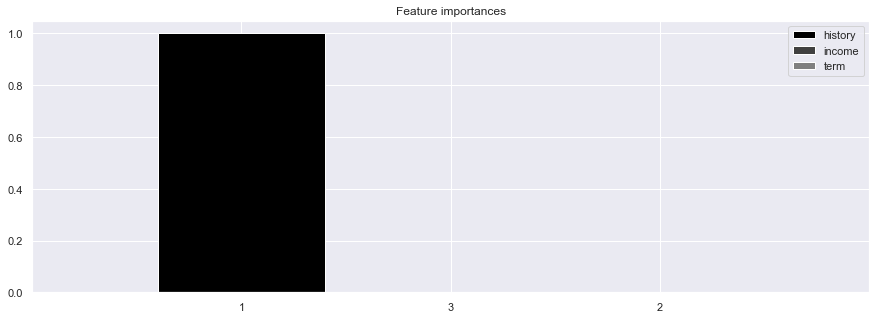

In [18]:
plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i / float(num_to_plot +  1)) for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f" + str(i)]) for i in feature_indices]);

    РАНДОМНЫЙ ЛЕС

In [19]:
from sklearn.ensemble import RandomForestClassifier

rc = RandomForestClassifier(random_state=42)
rc.fit(X_train, y_train)
y_pred = rc.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.3333333333333333

Попробуем улучшить результат с помощью гипперпараметров

In [28]:
rf = RandomForestClassifier()
rf_params = {'n_estimators': np.arange(5,41,5), 
             'max_depth': np.arange(2, 11),
             'min_samples_split': np.arange(2, 11), 
             'min_samples_leaf': np.arange(2, 11), 
             'max_features': np.arange(1, 4)}
rf_grid = GridSearchCV(rf, rf_params, cv=kf, scoring='accuracy', n_jobs = -1)
rf_grid.fit(X_train, y_train)
print("Найлучшее качество модели при", rf_grid.best_params_)
print("Наилучшая оценка качества модели:", rf_grid.best_score_)

Найлучшее качество модели при {'max_depth': 2, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
Наилучшая оценка качества модели: 0.8


In [35]:
rf = RandomForestClassifier(n_estimators= 5, 
                            max_depth=2, 
                            min_samples_split=2, 
                            min_samples_leaf=2, 
                            max_features=1)

rf.fit(X_train, y_train)
estimator = rf.estimators_[3]

export_graphviz(estimator, out_file='tree_from_rf.dot', feature_names = X.columns)

export_graphviz(tree, out_file='tree_from_rf.dot', feature_names=X.columns)
print(open('tree_from_rf.dot').read())

digraph Tree {
node [shape=box, fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="history <= 2.5\ngini = 0.278\nsamples = 6\nvalue = [5, 1]"] ;
1 [label="gini = 0.0\nsamples = 4\nvalue = [4, 0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.5\nsamples = 2\nvalue = [1, 1]"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}


![](https://dreampuf.github.io/GraphvizOnline/#digraph%20Tree%20%7B%0Anode%20%5Bshape%3Dbox%2C%20fontname%3D%22helvetica%22%5D%20%3B%0Aedge%20%5Bfontname%3D%22helvetica%22%5D%20%3B%0A0%20%5Blabel%3D%22history%20%3C%3D%202.5%5Cngini%20%3D%200.278%5Cnsamples%20%3D%206%5Cnvalue%20%3D%20%5B5%2C%201%5D%22%5D%20%3B%0A1%20%5Blabel%3D%22gini%20%3D%200.0%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20%5B4%2C%200%5D%22%5D%20%3B%0A0%20-%3E%201%20%5Blabeldistance%3D2.5%2C%20labelangle%3D45%2C%20headlabel%3D%22True%22%5D%20%3B%0A2%20%5Blabel%3D%22gini%20%3D%200.5%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20%5B1%2C%201%5D%22%5D%20%3B%0A0%20-%3E%202%20%5Blabeldistance%3D2.5%2C%20labelangle%3D-45%2C%20headlabel%3D%22False%22%5D%20%3B%0A%7D)

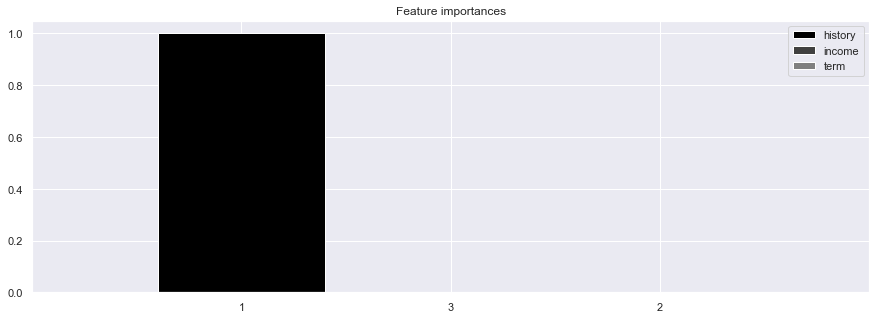

In [36]:
plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i / float(num_to_plot +  1)) for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f" + str(i)]) for i in feature_indices]);